# The `video to frames` notebook
It is to extract indicated number of frames from given video and stack them horizontally. 
The output stacked images are used to visualize the motion data in static media (paper, thesis, etc).

In [2]:
import os
import cv2
import math


def video_to_frames(video_path: str, save_path: str="", num_frames: int=18, crop=(150, 200, 100, 100)):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame interval
    frame_interval = math.floor(total_frames / num_frames)

    # Initialize an empty list to store the frames
    frames = []

    # Loop through the video frames and extract the frames at the specified interval
    for i in range(0, total_frames, frame_interval):
        # Set the frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        # Read the frame
        ret, frame = cap.read()
        # Remove the white border (assuming a 5-pixel border)
        # frame = cv2.copyMakeBorder(frame, 30, 20, 20, 30, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        h, w, _ = frame.shape
        cropped = frame[(h-crop[0])//2:(h-crop[1])//2+crop[1], (w-crop[2])//2:(w-crop[3])//2+crop[3], :]
        # Add the frame to the list
        frames.append(cropped)
    
    # Concatenate the frames horizontally
    frame_array = cv2.hconcat(frames[:num_frames])

    # Save the concatenated frames as a single image with higher resolution
    save_path = save_path or video_path.replace('.mp4', '.png')
    cv2.imwrite(save_path, frame_array)
    return frame_array


In [2]:
# file_path = '/home/ctq566/motion-diffusion-model/save/in_thesis/sample16_rep00.mp4'
# video_to_frames(file_path, save_path='/home/ctq566/motion-diffusion-model/save/in_thesis/sample16_rep00.png')

# The prompt-to-prompt results visualization
We first implement a function that accepts a list of video paths and convert them into images first then stack the images vertically.

In [3]:
import os
import matplotlib.pyplot as plt


def output_images(video_paths, save_path, visualize=True):
    if not isinstance(video_paths, list):
        video_paths = [video_paths]
    os.makedirs(save_path, exist_ok=True)
    assert os.path.isdir(save_path), 'save_path must be a directory'

    images = []
    for video_path in video_paths:
        image_path = os.path.join(save_path, os.path.basename(video_path).replace('.mp4', '.png'))
        image = video_to_frames(video_path, image_path)
        images.append(image)
    
    # Stack the images vertically
    image_array = cv2.vconcat(images)
    cv2.imwrite(os.path.join(save_path, 'vstack_output.png'), image_array)
    if visualize:
        plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    return image_array


def get_paths(path_template, p2p_threshold, sample_id):
    return [path_template.format(int(p2p_threshold * 100), sample_id),
            path_template.format(int(p2p_threshold * 100), sample_id + 1),
            path_template.format(int(p2p_threshold * 100), sample_id + 2)]


def process_p2p_results(path_template, p2p_threshold, sample_id, save_path):
    video_paths = get_paths(path_template, p2p_threshold, sample_id)
    os.makedirs(save_path, exist_ok=True)
    output_images(video_paths, save_path)


path_template = '../save/p2p_quaternion_2_random_3/{:03d}/sample{:02d}_rep00.mp4'
        

## 1. Speed and Duration Edits
### a. Modifying speed or pacing

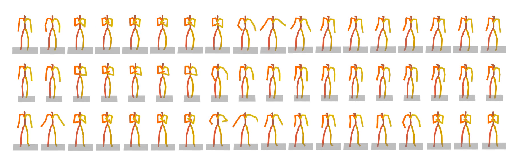

In [4]:
process_p2p_results(path_template, p2p_threshold=0.07, sample_id=0, save_path='./p2p_results/1a/')

### b. Changing the duration of the motion

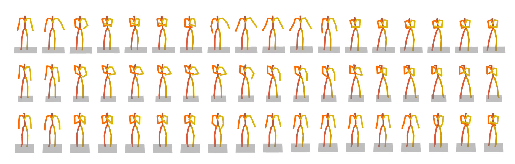

In [5]:
process_p2p_results(path_template, p2p_threshold=0.1, sample_id=4, save_path='./p2p_results/1b/')

## 2. Direction and Orientation Edits
### a. Changing direction


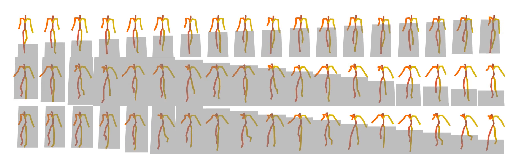

In [6]:
process_p2p_results(path_template, p2p_threshold=0.04, sample_id=8, save_path='./p2p_results/2a/')

### b. Adjusting orientation

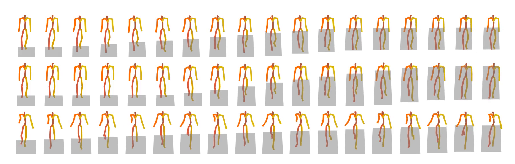

In [7]:
process_p2p_results(path_template, p2p_threshold=0.1, sample_id=12, save_path='./p2p_results/2b/')

## 3. Body Part and Joint Edits	
### a. Changing body parts involved


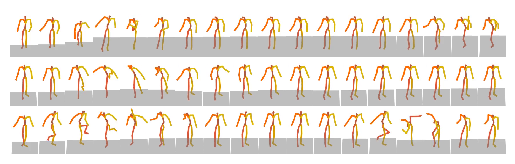

In [8]:
process_p2p_results(path_template, p2p_threshold=0.04, sample_id=16, save_path='./p2p_results/3a/')

### b. Adjusting joint angles

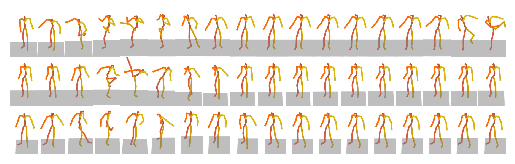

In [9]:
process_p2p_results(path_template, p2p_threshold=0.07, sample_id=20, save_path='./p2p_results/3b/')

## 4. Action and Pose Edits	
### a. Introducing new actions or poses

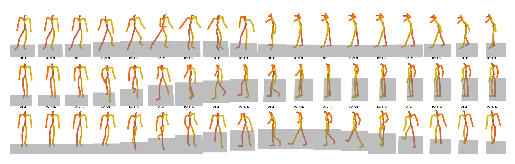

In [10]:
process_p2p_results(path_template, p2p_threshold=0.07, sample_id=24, save_path='./p2p_results/4a/')

### b. Removing or replacing actions

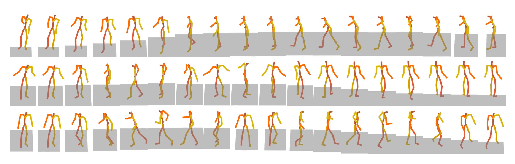

In [11]:
process_p2p_results(path_template, p2p_threshold=0.05, sample_id=28, save_path='./p2p_results/4b/')

## 5. Interaction Edits:	
### a. Interacting with objects

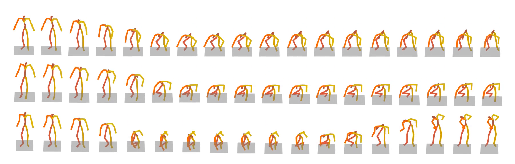

In [12]:
process_p2p_results(path_template, p2p_threshold=0.07, sample_id=32, save_path='./p2p_results/5a/')

### b. Interacting with other characters

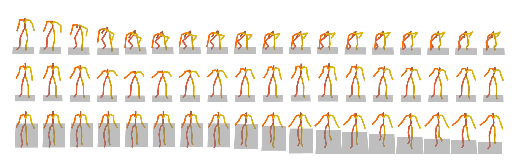

In [13]:
process_p2p_results(path_template, p2p_threshold=0.01, sample_id=36, save_path='./p2p_results/5b/')

## 6. Emotional and Style Edits	
### a. Altering the emotional context or intention

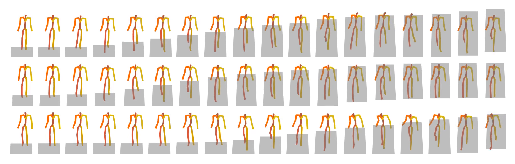

In [14]:
process_p2p_results(path_template, p2p_threshold=0.08, sample_id=40, save_path='./p2p_results/6a/')

### b. Changing the motion style or manner

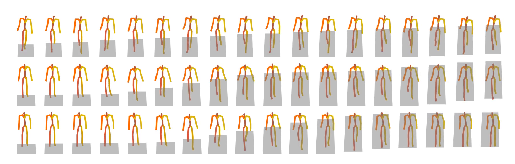

In [15]:
process_p2p_results(path_template, p2p_threshold=0.07, sample_id=44, save_path='./p2p_results/6b/')

## The T2M-GPT results visualization
First we convert the `.npy` files (generated by t2m-gpt) to `.mp4` files (using MDM visualization code)

In [1]:
import numpy as np
import os
import sys
sys.path.append('/home/ctq566/motion-diffusion-model/')

from data_loaders.humanml.utils.plot_script import plot_3d_motion
import data_loaders.humanml.utils.paramUtil as paramUtil


def my_plot_3d_motion(save_path, motion, skeleton=paramUtil.t2m_kinematic_chain, dataset='humanml', fps=20, title=''):
    plot_3d_motion(save_path, skeleton, motion, title, dataset, fps=fps)


In [4]:
# Visualize the T2M-GPT results
titles = ["The person jumps 3 times and sits down.",
          "The man jumped twice, then fell to the ground.",
          "The person is walking in a curve to the left and then back around to the right in a curve.",
          "A person is bouldering.",]
t2m_gpt_template = '../save/comparisons/t2m_gpt/t2m_gpt_{}.npy'
save_path = '../save/comparisons/t2m_gpt/'
t2m_gpt_data = [np.load(t2m_gpt_template.format(i))[0] for i in range(4)]
for i in range(4):
    my_plot_3d_motion(
        save_path=f'../save/comparisons/t2m_gpt/t2m_gpt_{i}.mp4', motion=t2m_gpt_data[i], title=titles[i])
    

In [5]:
for i in range(4):
    print(t2m_gpt_data[i].shape)

(72, 22, 3)
(116, 22, 3)
(192, 22, 3)
(88, 22, 3)


# Comparisons: MDM, MLD, and T2M-GPT

In [40]:
import glob


model_names = ['mdm', 'mld', 't2m_gpt']
path_template  = '../notebooks/comparisons/{}'
for model_name in model_names:
    path = path_template.format(model_name)
    for file in glob.glob(path + '/*.mp4'):
        video_to_frames(file, save_path=file.replace('.mp4', '.png'))
        

# MDM Latent Interpolation

In [3]:
import glob


input_videos = sorted(glob.glob('/home/ctq566/motion-diffusion-model/save/interpolation/interpolation*.mp4'))
for file in input_videos:
    video_to_frames(file, save_path=file.replace('.mp4', '.png'))

# Ablation Study: Prompt-to-Prompt threshold


In [15]:
threshold_choices = [0.01, 0.05, 0.1]
file_dir = '/home/ctq566/motion-diffusion-model/save/p2p_quaternion_2_random/{:03d}/'
output_dir = '/home/ctq566/motion-diffusion-model/save/p2p_quaternion_2_random_ablation/'
os.makedirs(output_dir, exist_ok=True)

motion_id = 32
for threshold in threshold_choices:
    for i in range(3):
        file_name = f'sample{motion_id + i:02d}_rep00.mp4'
        file_path = os.path.join(file_dir.format(int(threshold * 100)),  file_name)
        video_to_frames(file_path, save_path=os.path.join(output_dir, f'{int(threshold * 100):03d}_{file_name.replace(".mp4", ".png")}'))

# MLD rendering results

In [32]:
import numpy as np
import glob

for file in glob.glob('/home/ctq566/motion-diffusion-model/save/mld_npy4mesh/*mesh.mp4'):
    frames = video_to_frames(file, save_path=file.replace('.mp4', '.png'), crop=(1000, 1000, 1000, 1000))
    # create a directory for each mp4 file
    os.makedirs(file.replace('.mp4', ''), exist_ok=True)
    # save each frame as a separate file in a separate folder
    for i, frame in enumerate(np.split(frames, 18, axis=1)):
        cv2.imwrite(os.path.join(file.replace('.mp4', ''), f'{i:04d}.png'), frame, params=[cv2.IMWRITE_PNG_COMPRESSION, 0, cv2.IMWRITE_PNG_STRATEGY, cv2.IMWRITE_PNG_STRATEGY_FIXED])
    